# Project - ECG Arrhythmia Classification
### Natalia Kolińska, Alicja Smaruj, Dorota Woźna, Kacper Zielak


#### Imports

In [4]:
#pip install -r requirements.txt

In [2]:
#Załadowanie pakietów
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
import numpy as np
from scikit_posthocs import posthoc_dunn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#### Load data
Source: [Kaggle](https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset?select=Sudden+Cardiac+Death+Holter+Database.csv)

In [3]:
df_1 = pd.read_csv("data/INCART 2-lead Arrhythmia Database.csv")
df_2 = pd.read_csv("data/MIT-BIH Arrhythmia Database.csv")
df_3 = pd.read_csv("data/MIT-BIH Supraventricular Arrhythmia Database.csv")
test_data = pd.read_csv("data/Sudden Cardiac Death Holter Database.csv")

C:\Users\HP 840 G3\AppData\Local\Temp\ipykernel_5488\4005990507.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("data/Sudden Cardiac Death Holter Database.csv")


In [4]:
train_data = pd.concat([df_1, df_2, df_3])
train_data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,I01,N,163.0,165.0,0.069610,-0.083281,0.614133,-0.392761,0.047159,15,...,-0.023370,14,3,23,6,-0.023370,-0.011650,0.082608,0.101373,-0.183387
1,I01,N,165.0,166.0,-0.097030,0.597254,-0.078704,-0.078704,-0.137781,3,...,0.081637,15,5,27,7,0.081637,0.102992,0.191225,0.217544,-0.068248
2,I01,N,166.0,102.0,0.109399,0.680528,-0.010649,-0.010649,-0.720620,6,...,-0.148539,33,13,52,6,-0.148539,-0.060620,0.081080,0.204400,0.335172
3,I01,VEB,102.0,231.0,0.176376,0.256431,-0.101098,-0.707525,-0.101098,4,...,0.046898,21,9,34,4,0.046898,0.083728,0.279512,0.526785,0.450969
4,I01,N,231.0,165.0,0.585577,0.607461,-0.083499,-0.083499,-0.167858,3,...,-0.112552,32,5,43,6,-0.112552,0.012989,0.091491,0.134004,0.265232


In [5]:
test_data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,30.0,N,2.0,194.0,0.003261,0.159554,-0.046726,-0.046726,-0.129022,4.0,...,-0.131451,29.0,17.0,95.0,49.0,-0.131451,-0.015809,0.109493,-0.153622,-0.200331
1,30.0,N,194.0,188.0,-0.058462,0.067970,0.285091,-0.272093,-0.062109,25.0,...,-0.048727,25.0,2.0,76.0,49.0,-0.048727,0.034657,0.282264,-0.013981,-0.226871
2,30.0,N,188.0,194.0,-0.012959,-0.089749,0.329466,-0.204659,-0.012971,29.0,...,-0.005256,29.0,5.0,53.0,19.0,-0.005256,0.007639,0.116198,0.271552,-0.114414
3,30.0,N,194.0,198.0,-0.032815,-0.113236,0.398437,-0.178191,-0.068497,36.0,...,-0.069992,35.0,26.0,76.0,15.0,-0.069992,-0.049489,0.030777,0.378075,-0.074389
4,30.0,N,198.0,196.0,-0.047353,0.164835,0.364677,-0.207953,-0.061457,39.0,...,-0.072007,35.0,25.0,115.0,55.0,-0.072007,-0.053251,0.044583,0.313201,-0.157637


#### Explore data

Dependent variable
- N (Normal),
- SVEB (Supraventricular ectopic beat),
- VEB (Ventricular ectopic beat),
- F (Fusion beat),
- Q (Unknown beat).

In [6]:
train_data.groupby("type").size()

type
F         1045
N       405824
Q          100
SVEB     16931
VEB      36946
dtype: int64

In [7]:
test_data.groupby("type").size()

type
F          211
N       403528
Q         6520
SVEB      1609
VEB      14723
dtype: int64

Zbiór danych zawiera cechy utworzone na podstawie wynikow EKG serca. Podawane są wysokości lub szerokości wyliczone między specyficznymi momentami w szeregu czasowym. Pozwala to na zastosowanie uczenia maszynowego do klasyfikacji szeregów czasowych.

<img src="images/wykres_ecg.png" alt="Wykres" width="400"/>
<img src="images/prepost.png" alt="Wykres2" width="400"/>

Autorzy zbioru utworzyli 16 zmiennych. Zbadali je na surowych szeregach czasowych (a) oraz przetworzonych szeregach na których usunięto szum (b).Stąd 32 kolumny z pomiarami. Surowe dane mają przedrostek '0' a przetworzone '1'.

<img src="images/LeadAB.png" alt="Wykres2" width="800"/>

Check if anything is null

In [8]:
train_data.isnull().any()

record            False
type              False
0_pre-RR          False
0_post-RR         False
0_pPeak           False
0_tPeak           False
0_rPeak           False
0_sPeak           False
0_qPeak           False
0_qrs_interval    False
0_pq_interval     False
0_qt_interval     False
0_st_interval     False
0_qrs_morph0      False
0_qrs_morph1      False
0_qrs_morph2      False
0_qrs_morph3      False
0_qrs_morph4      False
1_pre-RR          False
1_post-RR         False
1_pPeak           False
1_tPeak           False
1_rPeak           False
1_sPeak           False
1_qPeak           False
1_qrs_interval    False
1_pq_interval     False
1_qt_interval     False
1_st_interval     False
1_qrs_morph0      False
1_qrs_morph1      False
1_qrs_morph2      False
1_qrs_morph3      False
1_qrs_morph4      False
dtype: bool

In [9]:
test_data.isnull().any()

record            True
type              True
0_pre-RR          True
0_post-RR         True
0_pPeak           True
0_tPeak           True
0_rPeak           True
0_sPeak           True
0_qPeak           True
0_qrs_interval    True
0_pq_interval     True
0_qt_interval     True
0_st_interval     True
0_qrs_morph0      True
0_qrs_morph1      True
0_qrs_morph2      True
0_qrs_morph3      True
0_qrs_morph4      True
1_pre-RR          True
1_post-RR         True
1_pPeak           True
1_tPeak           True
1_rPeak           True
1_sPeak           True
1_qPeak           True
1_qrs_interval    True
1_pq_interval     True
1_qt_interval     True
1_st_interval     True
1_qrs_morph0      True
1_qrs_morph1      True
1_qrs_morph2      True
1_qrs_morph3      True
1_qrs_morph4      True
dtype: bool

Check how many percentage are null values in test_data

In [10]:
round(test_data.isnull().sum() * 100 / len(test_data), 2)

record            15.16
type              15.16
0_pre-RR          15.16
0_post-RR         15.16
0_pPeak           15.16
0_tPeak           15.16
0_rPeak           15.16
0_sPeak           15.16
0_qPeak           15.16
0_qrs_interval    15.16
0_pq_interval     15.16
0_qt_interval     15.16
0_st_interval     15.16
0_qrs_morph0      15.16
0_qrs_morph1      15.16
0_qrs_morph2      15.16
0_qrs_morph3      15.16
0_qrs_morph4      15.16
1_pre-RR          34.73
1_post-RR         34.73
1_pPeak           34.73
1_tPeak           34.73
1_rPeak           34.73
1_sPeak           34.73
1_qPeak           34.73
1_qrs_interval    34.73
1_pq_interval     34.73
1_qt_interval     34.73
1_st_interval     34.73
1_qrs_morph0      34.73
1_qrs_morph1      34.73
1_qrs_morph2      34.73
1_qrs_morph3      34.73
1_qrs_morph4      34.73
dtype: float64

<Axes: >

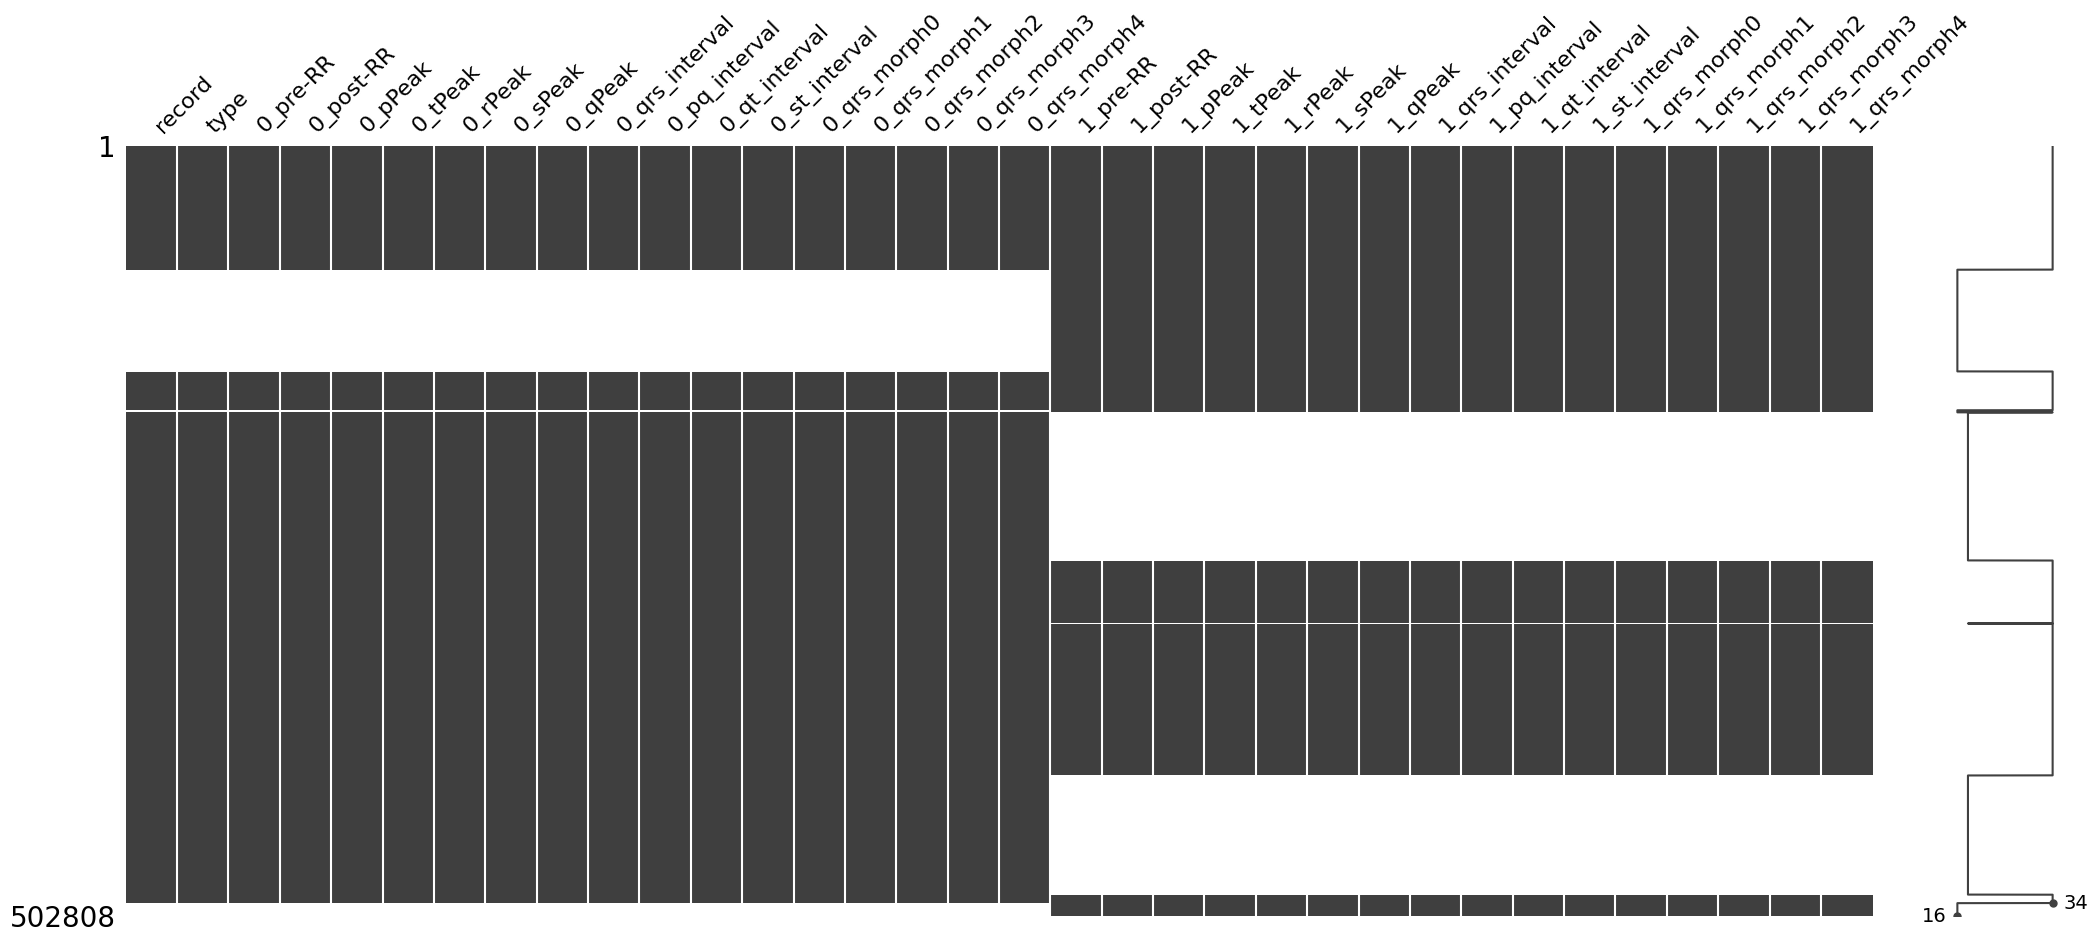

In [11]:
msno.matrix(test_data)

Check if outliers influence arrhythmia

In [12]:
print(
    "Q1:",
    train_data["0_pPeak"].quantile(0.25),
    "Q2:",
    train_data["0_pPeak"].quantile(0.5),
    "Q3:",
    train_data["0_pPeak"].quantile(0.75),
)
print("Min:", min(train_data["0_pPeak"]), "Max:", max(train_data["0_pPeak"]))

Q1: -0.05114678272548937 Q2: 0.0120459091030483 Q3: 0.11941641509086005
Min: -4.208600735 Max: 10.56590393


In [13]:
q3 = train_data["0_pPeak"].quantile(0.75)
print("Amount of outliers:", len(train_data.loc[train_data["0_pPeak"] > q3]))
print("Percentage of type in the outlier group")
train_data.loc[train_data["0_pPeak"] > q3].groupby("type").size() * 100 / len(train_data.loc[train_data["0_pPeak"] > q3])

Amount of outliers: 115212
Percentage of type in the outlier group


type
F        0.348922
N       75.889664
Q        0.057286
SVEB     4.189668
VEB     19.514460
dtype: float64

In [ ]:
#Jest bardzo dużo outlierów, ale czy powinniśmy je usunąć lub zastąpić? Możliwe, że to były mocniejsze uderzenia serca u zdrowych osób.

#### Prepare data

Remove 'record' column, because the name of the subject/patient is irrelevant in this study.

In [14]:
train_data = train_data.drop("record", axis=1)
test_data = test_data.drop("record", axis=1)

Remove null observations from test_data

In [15]:
test_data = test_data.dropna()
# len(test_data)

Split X and y

In [16]:
y_train = train_data["type"]
X_train = train_data.drop(columns=["type"])

In [17]:
y_test = test_data["type"]
X_test = test_data.drop(columns=["type"])

#### Visualisation

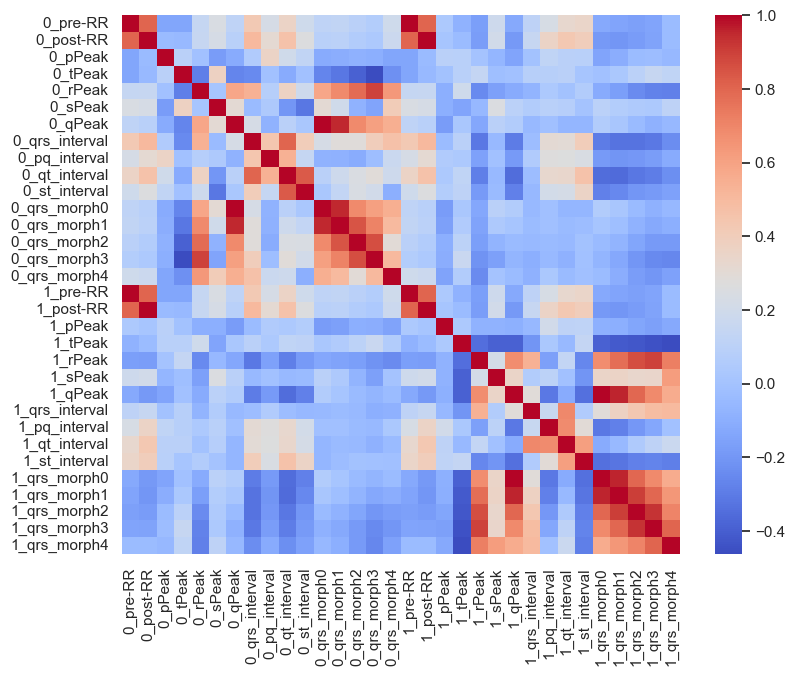

In [18]:
corr_matrix = X_train.corr()
plt.figure(figsize=(9,7))
sns.set_theme("notebook")
sns.set_palette("PuBuGn_d")
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.savefig("images/corplot.png")

In [19]:
train_data0 = train_data[["type", *[column_name for column_name in train_data.columns if column_name.startswith("0_")]]]

In [20]:
train_data1 = train_data[["type", *[column_name for column_name in train_data.columns if column_name.startswith("1_")]]]

Wykresy pudełkowe dla danych surowych (0) i przefiltrowanych (1) podzielone na grupy:
* pre-RR i post-RR
* peaks
* intervals
* morphology

In [ ]:


# Zbudowanie wykresów pudełkowych trwa ok. 3 minuty.
# Jeśli nie potrzebujesz wersji interaktywnej, możesz skorztstać z zapisanych obrazów. 

prepost_0=["0_pre-RR", "0_post-RR"]
data_to_box_0 = pd.melt(train_data0[["type", *prepost_0]], id_vars="type", value_vars=prepost_0)
fig1 = px.box(data_to_box_0, y="value", x="variable", color="type", width=1000)
fig1.write_image("images/box_RR_0.png")

prepost_1=["1_pre-RR", "1_post-RR"]
data_to_box_1 = pd.melt(train_data1[["type", *prepost_1]], id_vars="type", value_vars=prepost_1)
fig2 = px.box(data_to_box_1, y="value", x="variable", color="type", width=1000)
fig2.write_image("images/box_RR_1.png")

peaks_0=["0_pPeak", "0_tPeak", "0_rPeak", "0_sPeak", "0_qPeak"]
data_to_box_3 = pd.melt(train_data0[["type",*peaks_0]], id_vars="type", value_vars=peaks_0)
fig3= px.box(data_to_box_3, y="value", x="variable", color="type", width=1000)
fig3.write_image("images/box_peaks_0.png")

peaks_1=["1_pPeak", "1_tPeak", "1_rPeak", "1_sPeak", "1_qPeak"]
data_to_box4 = pd.melt(train_data1[["type", *peaks_1]], id_vars="type", value_vars=peaks_1)
fig4= px.box(data_to_box4, y="value", x="variable", color="type", width=1000)
fig4.write_image("images/box_peaks_1.png")

intervals_0=["0_qrs_interval", "0_pq_interval", "0_qt_interval", "0_st_interval"]
data_to_box5 = pd.melt(train_data0[["type", *intervals_0]], id_vars="type", value_vars=intervals_0)
fig5 = px.box(data_to_box5, y="value", x="variable", color="type", width=1000)
fig5.write_image("images/box_intervals_0.png")

intervals_1=["1_qrs_interval", "1_pq_interval", "1_qt_interval", "1_st_interval"]
data_to_box6 = pd.melt(train_data1[["type", *intervals_1]], id_vars="type", value_vars=intervals_1)
fig6 = px.box(data_to_box6, y="value", x="variable", color="type", width=1000)
fig6.write_image("images/box_intervals_1.png")

morphs_0=["0_qrs_morph0", "0_qrs_morph1", "0_qrs_morph2", "0_qrs_morph3", "0_qrs_morph4",]
data_to_box7 = pd.melt(train_data0[["type", *morphs_0]], id_vars="type", value_vars=morphs_0)
fig7 = px.box(data_to_box7, y="value", x="variable", color="type")
fig7.write_image("images/box_morphs_0.png")

morphs_1=["1_qrs_morph0", "1_qrs_morph1", "1_qrs_morph2", "1_qrs_morph3", "1_qrs_morph4",]
data_to_box8 = pd.melt(train_data1[["type", *morphs_1]], id_vars="type", value_vars=morphs_1)
fig8 = px.box(data_to_box8, y="value", x="variable", color="type")
fig8.write_image("images/box_morphs_1.png")

#### Standaryzacja oryginalnych danych

In [21]:
std_all = StandardScaler()
train_data_std = std_all.fit_transform(X_train)
train_data_std = pd.DataFrame(train_data_std, columns=X_train.columns)

test_data_std = std_all.transform(X_test)
test_data_std = pd.DataFrame(test_data_std, columns=X_test.columns)

#### PCA

In [22]:
pca = PCA(n_components=2)
components = pca.fit_transform(train_data_std)

fig = px.scatter(components, x=0, y=1, color=y_train, width=800)
fig.write_image("images/pca_2d.png")
# fig.show()

#### Dummy model

Stworzono "głupi" model, który będzie służył do porównań, czy nasze modele uzyskują lepsze wyniki. Przyjęto strategię most-frequent, co będzie skutkowało zaklysyfikowaniem wszystkich obserwacji jako N (normalne).

In [ ]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(train_data_std, y_train)
y_pred = dummy_model.predict(test_data_std)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_test, y_pred, average="weighted", zero_division=np.nan)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average="weighted")
print("Sensitivity (recall):", recall)

# specificity = specificity_score(y_test, y_pred)
# print("Specificity :", specificity, average="weighted")

f1 = f1_score(y_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9480545766263454
Balanced accuracy: 0.2
Precision: 0.9480545766263454
Sensitivity (recall): 0.9480545766263454
F1-Score: 0.9227744346041066


#### Model 1 - Natalia

##### Krok 1: Budowa modelu RandomForest

In [ ]:

ma_train = []
ma_test = []


for j in range(1, 11):
    RFmodel = RandomForestClassifier(random_state=10, max_depth=j, n_estimators=10)
    a_test = []
    a_tren = []

    
    RFmodel.fit(X_train, y_train)
    
    a_tren.append(RFmodel.score(X_train, y_train).round(4))
    a_test.append(RFmodel.score(X_test, y_test).round(4))

    ma_test.append(np.mean(a_test))
    ma_train.append(np.mean(a_tren))



print("Wyniki na zbiorze treningowym:", ma_train)
print("Wyniki na zbiorze testowym:", ma_test)

##### Krok 2: Wybór głębokości drzewa

Optymalna głębokość: 10


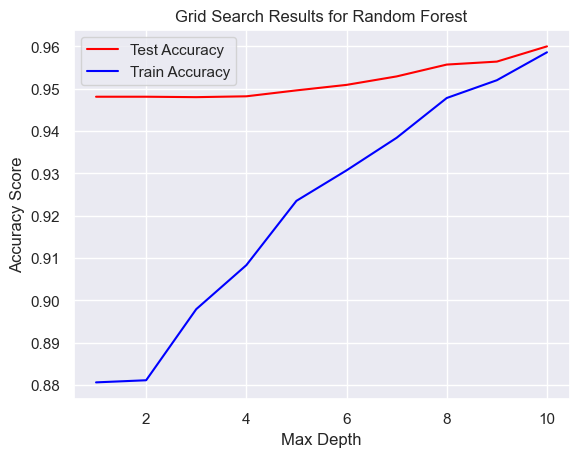

In [62]:
# Indeks głębokości drzewa, która daje najlepszą średnią dokładność testu
optimal_depth = np.argmax(ma_test) + 1
print("Optymalna głębokość:", optimal_depth)

depths = range(1, 11)  
plt.plot(depths, ma_test, label="Test Accuracy", color="red")
plt.plot(depths, ma_train, label="Train Accuracy", color="blue")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Grid Search Results for Random Forest")
plt.legend()
plt.show()


##### Wybór liczby drzew w lesie

In [ ]:
n_estimators_values = [50, 100, 150, 200, 250]
ma_train = []
ma_test = []

for n_estimators in n_estimators_values:
    RFmodel = RandomForestClassifier(random_state=10, n_estimators=n_estimators)
    
    RFmodel.fit(X_train, y_train)
    
    ma_train.append(RFmodel.score(X_train, y_train).round(4))
    ma_test.append(RFmodel.score(X_test, y_test).round(4))

optimal_n_estimators = n_estimators_values[np.argmax(ma_test)]
print("Optymalna wartość n_estimators:", optimal_n_estimators)


plt.plot(n_estimators_values, ma_test, label="Test Accuracy", color="red")
plt.plot(n_estimators_values, ma_train, label="Train Accuracy", color="blue")
plt.xlabel("N_estimators")
plt.ylabel("Accuracy Score")
plt.title("Grid Search Results for Random Forest")
plt.legend()
plt.show()


##### Zbudowanie modelu na wszystkich danych treningowych

In [64]:

# Inicjalizacja modelu Random Forest z optymalną głębokością oraz liczbą drzew
model_rf_final = RandomForestClassifier(random_state=10, max_depth=optimal_depth, n_estimators=optimal_n_estimators)

# Trenowanie modelu na pełnym zbiorze treningowym
model_rf_final.fit(train_data_std, y_train)

RandomForestClassifier(max_depth=10, n_estimators=250, random_state=10)

#### Ocena dokładności

In [65]:
y_pred = model_rf_final.predict(test_data_std)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average="weighted")
print("Sensivity (recall):", recall)

f1 = f1_score(y_test, y_pred, average="weighted")
print("F1-Score:", f1)

Accuracy: 0.9605359240562593
Balanced accuracy: 0.257895374303332


c:\Users\HP 840 G3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Precision: 0.9542958212592638
Sensivity (recall): 0.9605359240562593
F1-Score: 0.9487479886097301


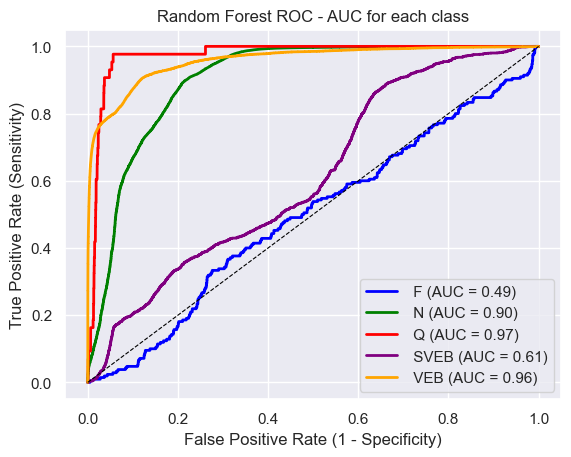

In [68]:
from sklearn.metrics import roc_curve, auc
# Przewidywania modelu Random Forest
y_pred_proba = model_rf_final.predict_proba(test_data_std)

fpr_list = []
tpr_list = []
roc_auc_list = []

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

class_labels = ['F', 'N', 'Q', 'SVEB', 'VEB']  

for i in range(len(np.unique(y_test))):
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_test_bin = y_test_bin[:, i]
    y_pred_bin = label_binarize(model_rf_final.predict(test_data_std), classes=np.unique(y_test))
    y_pred_prob = y_pred_proba[:, i]

    fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    # Przypisanie koloru z listy dostępnych kolorów
    color = colors[i % len(colors)]
    
    # Ustaw etykiety na legendzie zamiast oryginalnych klas
    plt.plot(fpr, tpr, lw=2, label=f' {class_labels[i]} (AUC = {roc_auc:.2f})', color=color)

plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=0.8)
plt.title("Random Forest ROC - AUC for each class")
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

##### Oversampling i undersampling

In [40]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

ma_train = []
ma_test = []

optimal_depth = 10
optimal_n_estimators = 250


# Tworzenie modelu Random Forest
RFmodel = RandomForestClassifier(random_state=10, max_depth=optimal_depth, n_estimators=optimal_n_estimators)


# Tworzenie pipeline'a z oversamplingiem i undersamplingiem
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('model', RFmodel)
])

# Trenowanie modelu na danych po zastosowaniu oversamplingu i undersamplingu
pipeline.fit(X_train, y_train)

# Ocena modelu na danych testowych
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average="weighted")
print("Sensitivity (recall):", recall)

f1 = f1_score(y_test, y_pred, average="weighted")
print("F1-Score:", f1)


Accuracy: 0.8911166142807252
Balanced accuracy: 0.3412479279043793
Precision: 0.964214168426584
Sensitivity (recall): 0.8911166142807252
F1-Score: 0.9260806658121893


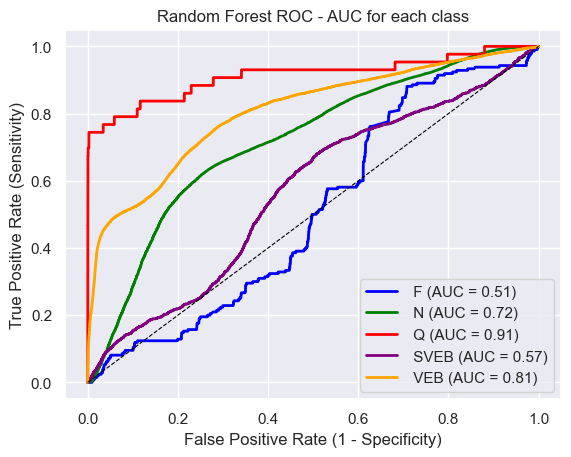

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Przewidywania modelu Random Forest
y_pred_proba = pipeline.predict_proba(test_data_std)

fpr_list = []
tpr_list = []
roc_auc_list = []

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
 
class_labels = ['F', 'N', 'Q', 'SVEB', 'VEB']  

for i in range(len(np.unique(y_test))):
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_test_bin = y_test_bin[:, i]
    y_pred_bin = label_binarize(pipeline.predict(test_data_std), classes=np.unique(y_test))
    y_pred_prob = y_pred_proba[:, i]

    fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    # Przypisanie koloru z listy dostępnych kolorów
    color = colors[i % len(colors)]
     # Ustaw etykiety na legendzie zamiast oryginalnych klas
    plt.plot(fpr, tpr, lw=2, label=f' {class_labels[i]} (AUC = {roc_auc:.2f})', color=color)

plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=0.8)
plt.title("Random Forest ROC - AUC for each class")
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

#### Model 2 - Dorota

##### Krok 1: Stworzenie nowych zmiennych i zbadanie istotności ich wpływu na rozróżnienie grup

In [ ]:
# Na podstawie wykresów pudełkowych box_RR_0 i box_RR_1 można zauważyć, że w przypadku zaburzenia SVEB, preRR jest często krótsze niż postRR,
# dlatego dodano dwie zmienne opisujące ich różnice.
data_new=pd.DataFrame()
data_new["0_RR_diff"] = X_train["0_pre-RR"] - X_train["0_post-RR"]
data_new["1_RR_diff"] = X_train["1_pre-RR"] - X_train["1_post-RR"]
data_new["type"] =  y_train

def perform_dunn_test(data, column, group="type", p_adjust="fdr_bh"):
    dunn_df = posthoc_dunn(data, val_col=column, group_col=group, p_adjust=p_adjust)
    remove = np.tril(np.ones(dunn_df.shape), k=0).astype(bool)
    dunn_df[remove] = np.nan
    molten_df = dunn_df.melt(ignore_index=False).reset_index().dropna()
    molten_df.rename(columns={"value": f"{column}_sign"}, inplace=True)
    return molten_df

molten_df1 = perform_dunn_test(data_new, "0_RR_diff")
molten_df2 = perform_dunn_test(data_new, "1_RR_diff")

dunn_summ = pd.merge(molten_df1, molten_df2)

# wskazanie istotnych
def color_red(val):
    color = "red" if val <= 0.05 else "black"
    return f"color: {color}"

# Stworzenie obiektu Styler i zastosowanie funkcji do kolumny "0_RR_diff"
dunn_summ = dunn_summ.style.applymap(color_red, subset=["0_RR_diff_sign",	"1_RR_diff_sign"])
dunn_summ

C:\Users\HP 840 G3\AppData\Local\Temp\ipykernel_8320\3054995726.py:27: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,index,variable,0_RR_diff_sign,1_RR_diff_sign
0,F,N,0.382275,0.382275
1,F,Q,0.000251,0.000251
2,N,Q,0.000045,0.000045
3,F,SVEB,0.000000,0.000000
4,N,SVEB,0.000000,0.000000
5,Q,SVEB,0.000000,0.000000
6,F,VEB,0.000000,0.000000
7,N,VEB,0.000000,0.000000
8,Q,VEB,0.000000,0.000000
9,SVEB,VEB,0.000000,0.000000


Powyższe wyniki potwierdzają, że nowo utworzone zmienne istotnie różnicują wszystkie pary typów poza F i N. Następnie przeprowadzimy standaryzację dla nowych zmiennych.

##### Krok 2: pre-processing danych treningowych i testowych z nowymi zmiennymi

In [ ]:
X_train["0_RR_diff"] = X_train["0_pre-RR"] - X_train["0_post-RR"]
X_train["1_RR_diff"] = X_train["1_pre-RR"] - X_train["1_post-RR"]

X_test["0_RR_diff"] = X_test["0_pre-RR"] - X_test["0_post-RR"]
X_test["1_RR_diff"] = X_test["1_pre-RR"] - X_test["1_post-RR"]

In [ ]:
pipeline= Pipeline(
    [
        ('std_scaler', StandardScaler())
    ]
)

In [ ]:
train_data_prep = pipeline.fit_transform(X_train)
test_data_prep = pipeline.transform(X_test)

##### Krok 3: Budowa drzew decyzyjnych

In [ ]:
# drzewo decyzyjne z walidacją krzyżową i zbalansowaniem klas przy podziale na treningowe i testowe

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

ma_train = []
ma_test = []
for j in range(1, 21):
    model = tree.DecisionTreeClassifier(random_state=10, max_depth=j)
    a_test = []
    a_tren = []

    for i, (train_index, test_index) in enumerate(skf.split(train_data_prep, y_train)):
        model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        a_test.append(model.score(X_train.iloc[test_index], y_train.iloc[test_index]).round(4))
        a_tren.append(model.score(X_train.iloc[train_index], y_train.iloc[train_index]).round(4))

    ma_test.append(np.mean(a_test))
    ma_train.append(np.mean(a_tren))

##### Wybór głębokości drzewa

In [ ]:
depths = np.arange(1, 21)
plt.plot(depths, ma_test, label="Train Accuracy", color="blue")
plt.plot(depths, ma_train, label="Test Accuracy", color="red")
plt.xlabel("Max Depth")
plt.xticks(range(21))
plt.ylabel("Accuracy Score")
plt.title("Grid Search Results for Decision Tree")
plt.legend()
plt.grid(True)
plt.savefig("images/grid_search_trees.png")
plt.show()

Wybrano głębokość drzewa równą 8.

##### Zbudowanie modelu na wszystkich danych treningowych

In [ ]:
model = tree.DecisionTreeClassifier(random_state=10, max_depth=8)
model.fit(train_data_prep, y_train)

##### Ocena dokładności

In [ ]:
y_pred = model.predict(test_data_prep)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

precision = precision_score(y_test, y_pred, average="weighted")
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average="weighted")
print("Sensivity (recall):", recall)

f1 = f1_score(y_test, y_pred, average="weighted")
print("F1-Score:", f1)

In [ ]:
types=np.unique(y_test.values)
conf_matrix=pd.DataFrame(confusion_matrix(y_test, y_pred, labels=types), columns=types, index=types)
percentage=conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
percentage = percentage.fillna(0)
plt.figure(figsize=(6, 4))
sns.heatmap(percentage, fmt='.2%', annot=True, annot_kws={"size": 12})
plt.xlabel("Predicted label");
plt.ylabel("True label");

Obserwacje typu F były w 92,86% przypadków mylone jako N.
99,39% wartości normalnych jest prawidłowo zaklysyfikowanych.
Żadna obserwacja typu Q nie została zaklasyfikowana poprawnie. Często były mylone z N lub SVEB.
Obserwacje typu SVEB były w 97,01% przypadków mylone z N.

##### Zmienne istotne

In [ ]:
indeksy = np.where(model.feature_importances_!=0)[0]
variables= [X_train.columns[i] for i in indeksy]
importances = model.feature_importances_[indeksy]

# sortowanie
importances, variables= zip(*sorted(zip(importances, variables), reverse=False))

# Tworzenie wykresu słupkowego z niezerowymi wartościami
fig, ax = plt.subplots(figsize=(7, 5))
plt.barh(variables[:15], importances[:15])

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Model 3 - Kacper